__Portfolio Optimization & Efficient Frontier__


__Modern Portfolio Theory__

Modern portfolio theory also popularly called Mean-Variance Portfolio Theory (MVP) is a major breakthrough in finance. It is based on the premise that returns are normally distributed and by looking at mean and variance, we can essentially describe the distribution of end-of-period wealth.

The basic idea of this theory is to achieve diversification by constructing a portfolio for a minimal portfolio risk or maximal portfolio returns. Accordingly, the Efficient Frontier is a set of optimal portfolios in the risk-return spectrum, and portfolios located under the Efficient Frontier curve are considered sub-optimal.

This means that the portfolios on the frontier offered

Highest expected return for a given level of risk

Lowest level of risk for a given level of expected returns

In essence, the investors' goal should be to select a level of risk that he/she is comfortable with and then find a portfolio that maximizes returns based on the selected risk level.

In [31]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

# Import pandas & yfinance
import pandas as pd
import numpy as np
from numpy.linalg import multi_dot
import yfinance as yf

# Set numpy random seed
np.random.seed(42)

# Import cufflinks
import cufflinks as cf
cf.set_config_file(offline=True, dimensions=((1000,600)))

# Import plotly express for EF plot
import plotly.express as px
px.defaults.width, px.defaults.height = 1000, 600
                
# Set precision
pd.set_option('display.precision', 4)

In [3]:
# Import & create database 
from sqlalchemy import create_engine, text
engine = create_engine('sqlite:///Nifty50')

In [4]:
# # Read data from wikipedia - also refer Lab 1
nifty50 = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[2].Symbol.to_list()

# # Fetch data from yahoo using list comprehension
data = [yf.download(symbol+'.NS', start="2019-01-01", end="2023-12-31", progress=False).reset_index() for symbol in nifty50] 

# # Save it to database
for frame, symbol in zip(data, nifty50):
    frame.to_sql(symbol, engine, if_exists='replace', index=False)

In [5]:
# Specify assets / stocks - refer Lab 1
# Indian stocks : bank, consumer goods, diversified, tech, consumer durables 
assets = sorted(['ICICIBANK', 'ITC', 'RELIANCE', 'TCS', 'ASIANPAINT'])
print(assets)

# Number of assets
numofasset = len(assets)

# Number of portfolio for optimization
numofportfolio = 5000

['ASIANPAINT', 'ICICIBANK', 'ITC', 'RELIANCE', 'TCS']


In [6]:
# Query close price from database
df = pd.DataFrame()
for asset in assets:
    query = f'SELECT Date, Close FROM  {asset}'
    with engine.connect() as connection:
        df1 = pd.read_sql_query(text(query), connection, index_col='Date')
        df1.columns = [asset]
    df = pd.concat([df, df1], axis=1)

# View output
df

,ASIANPAINT,ICICIBANK,ITC,RELIANCE,TCS
Date,,,,,
2019-01-01 00:00:00.000000,1371.5500,363.75,282.70,1024.9669,1902.8000
2019-01-02 00:00:00.000000,1383.3000,364.60,280.60,1011.6177,1923.3000
2019-01-03 00:00:00.000000,1388.3000,363.25,278.85,999.1371,1899.9500
2019-01-04 00:00:00.000000,1385.8500,365.20,280.95,1004.5316,1876.8500
2019-01-07 00:00:00.000000,1396.0000,367.70,281.65,1010.1091,1897.9000
...,...,...,...,...,...
2023-12-22 00:00:00.000000,3341.3000,994.30,455.20,2565.0500,3824.0000
2023-12-26 00:00:00.000000,3383.3501,995.10,456.45,2578.0500,3795.5500
2023-12-27 00:00:00.000000,3404.4500,1002.25,457.10,2586.8501,3811.2000


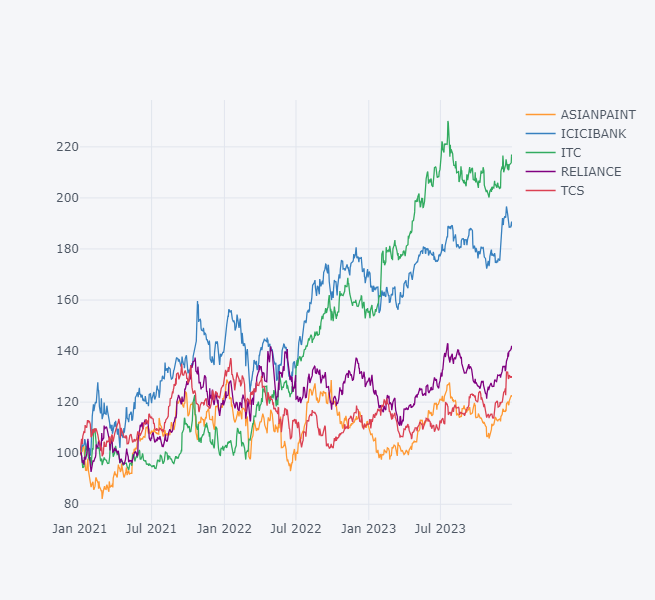

In [7]:
# Plot price history
df['2021':].normalize().iplot(kind='line')

In [8]:
# Dataframe of returns and volatility
returns = df.pct_change().dropna()
annual_returns = round(returns.mean()*260*100,2)
annual_stdev = round(returns.std()*np.sqrt(260)*100,2)

# Subsume into dataframe
df2 = pd.DataFrame({
    'Ann Ret': annual_returns,
    'Ann Vol': annual_stdev
})

# Get the output
df2

,Ann Ret,Ann Vol
ASIANPAINT,22.73,26.75
ICICIBANK,26.85,33.41
ITC,13.96,26.78
RELIANCE,24.24,30.89
TCS,17.72,25.22


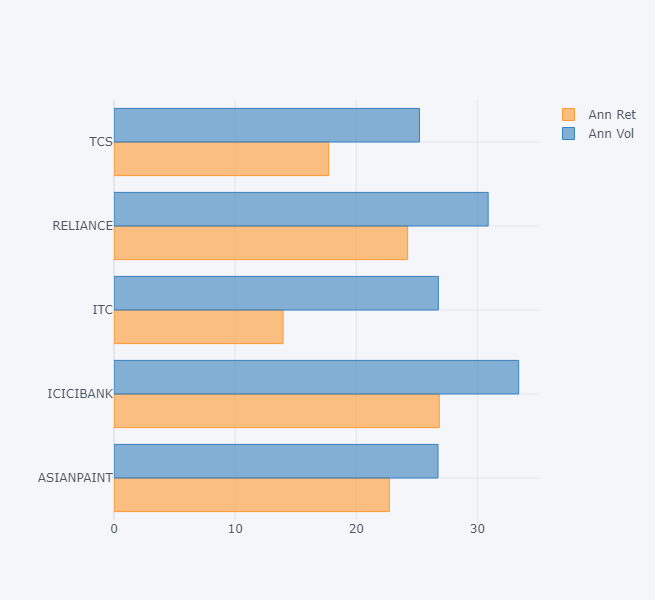

In [9]:
# Plot annualized return and volatility
df2.iplot(
    kind='bar',
    shared_xaxes=True,
    orientation='h'
)

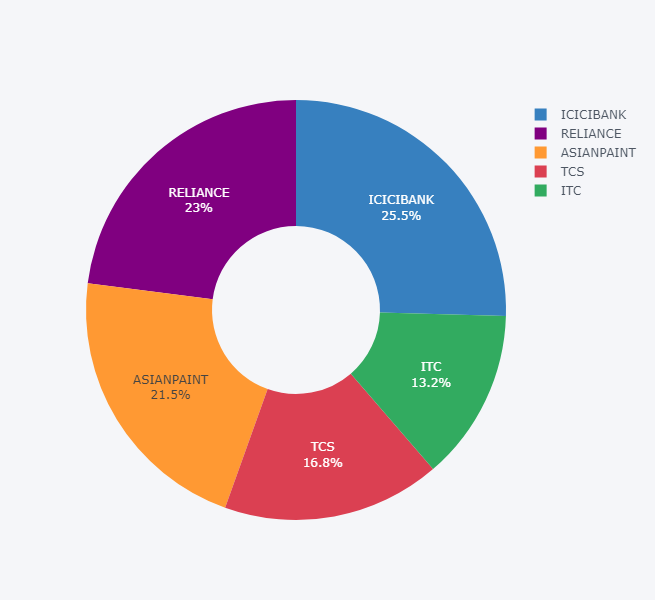

In [10]:
df2.reset_index().iplot(
    kind='pie',
    labels='index',
    values='Ann Ret',
    textinfo='percent+label',
    hole=0.4
)

__Portfolio Statistics__

Consider a portfolio which is fully invested in risky assets. Let 
w
 and 
μ
 be the vector of weights and mean returns of n assets.

Let 
$$
\mathbf{w} =
\begin{pmatrix}
w_1 \\
w_2 \\
\vdots \\
w_n
\end{pmatrix}
\quad \text{and} \quad
\mathbf{\mu} =
\begin{pmatrix}
\mu_1 \\
\mu_2 \\
\vdots \\
\mu_n
\end{pmatrix}
$$

where the sum of the weights is:

$$
\sum_{i=1}^n w_i = 1
$$

The expected portfolio return \( \mu_\pi \) is given by the dot product of the weights and the expected returns:

$$
\mu_\pi = \mathbf{w}^T \cdot \mathbf{\mu}
$$

which is equivalent to:

$$
\sum_{i=1}^n w_i \mu_i
$$

The expected portfolio variance \( \sigma^2_\pi \) is given by the multidot product of weights and the covariance matrix \( \Sigma \):

$$
\sigma^2_\pi = \mathbf{w}^T \cdot \Sigma \cdot \mathbf{w}
$$

where \( \Sigma \) is the covariance matrix:

$$
\Sigma =
\begin{pmatrix}
\Sigma_{1,1} & \cdots & \Sigma_{1,n} \\
\vdots & \ddots & \vdots \\
\Sigma_{n,1} & \cdots & \Sigma_{n,n}
\end{pmatrix}
$$

In [13]:
# Porfolio Simulation
# Write a user define function
def portfolio_simulation(returns):

    # initialize the lists
    rets = []; vols=[]; wts=[]

    # simulate 5000 portfolio
    for i in range(numofportfolio):

        # generate random weights
        weights = np.random.random(numofasset)

        # set weights such that sum of weights is equal to 1
        weights /= np.sum(weights)

        # portfolio stats
        rets.append(weights.T@np.array(returns.mean()*260))
        vols.append(np.sqrt(multi_dot([weights.T, returns.cov()*260, weights])))
        wts.append(weights)

    # create a dataframe for our analysis
    data = {'port_rets': rets, 'port_vols': vols}
    for counter, symbol in enumerate(returns.columns.tolist()):
        data[symbol+' weight '] = [w[counter] for w in wts]

    portdf = pd.DataFrame(data)
    portdf['sharpe_ratio'] = portdf['port_rets'] / portdf['port_vols']

    return round(portdf, 4)

In [14]:
#Maximum Sharpe Portfolio
# Create a dataframe for analysis
temp = portfolio_simulation(returns)
temp.head()

,port_rets,port_vols,ASIANPAINT weight,ICICIBANK weight,ITC weight,RELIANCE weight,TCS weight,sharpe_ratio
0,0.2189,0.2125,0.1332,0.3381,0.2603,0.2129,0.0555,1.0299
1,0.1855,0.1918,0.0653,0.0243,0.3625,0.2516,0.2963,0.9668
2,0.2097,0.2269,0.0093,0.4375,0.3755,0.0958,0.0820,0.9244
3,0.2034,0.1961,0.1057,0.1753,0.3024,0.2489,0.1678,1.0372
4,0.2074,0.1887,0.3279,0.0748,0.1566,0.1963,0.2444,1.0992


In [15]:
# Get the max sharpe portfolio stats
temp.iloc[temp.sharpe_ratio.idxmax()]

port_rets             0.2184
port_vols             0.1953
ASIANPAINT weight     0.3292
ICICIBANK weight      0.1820
ITC weight            0.0831
RELIANCE weight       0.1720
TCS weight            0.2336
sharpe_ratio          1.1182
Name: 553, dtype: float64

In [16]:
# Verify the above result
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
port_rets,5000.0,0.2110,0.0132,0.1614,0.2024,0.2110,0.2196,0.2537
port_vols,5000.0,0.2016,0.0117,0.1822,0.1933,0.1996,0.2078,0.2788
ASIANPAINT weight,5000.0,0.2012,0.1140,0.0000,0.1124,0.2001,0.2785,0.7079
ICICIBANK weight,5000.0,0.1973,0.1130,0.0000,0.1082,0.1985,0.2755,0.7488
ITC weight,5000.0,0.1996,0.1128,0.0000,0.1112,0.2009,0.2768,0.7678
RELIANCE weight,5000.0,0.2030,0.1119,0.0001,0.1155,0.2029,0.2805,0.7058
TCS weight,5000.0,0.1988,0.1117,0.0001,0.1103,0.1982,0.2752,0.6781
sharpe_ratio,5000.0,1.0477,0.0459,0.7027,1.0235,1.0570,1.0814,1.1182


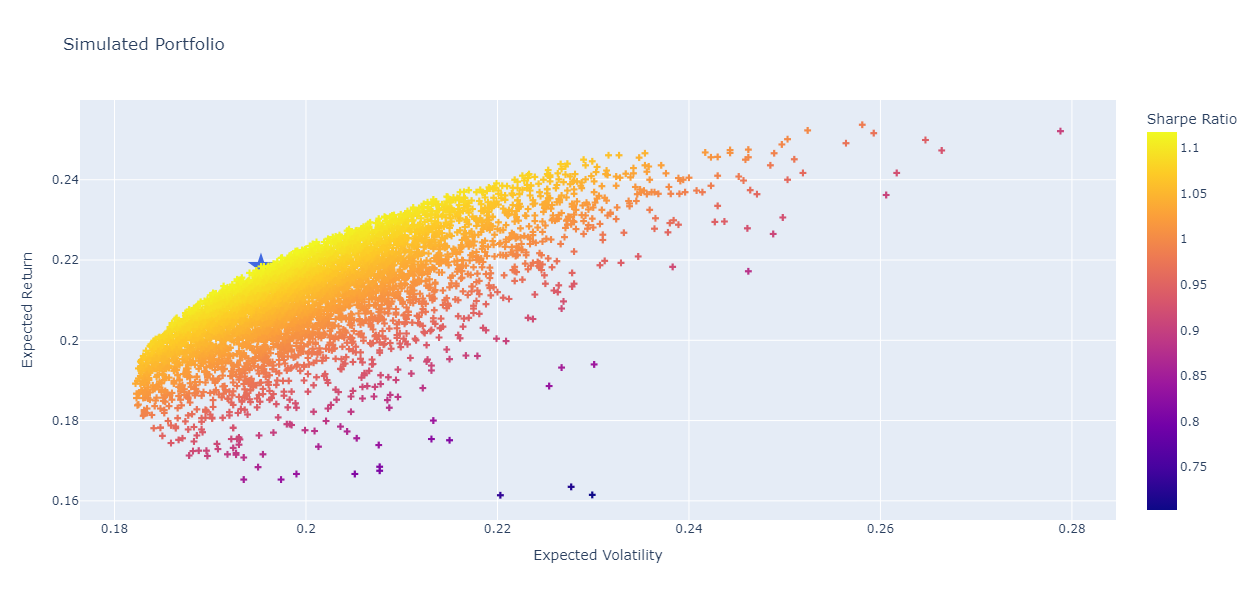

In [18]:
# Plot simulated portfolio
fig = px.scatter(
    temp, x='port_vols', y='port_rets', color='sharpe_ratio', 
    labels={'port_vols': 'Expected Volatility', 'port_rets': 'Expected Return','sharpe_ratio': 'Sharpe Ratio'},
    title="Simulated Portfolio"
     ).update_traces(mode='markers', marker=dict(symbol='cross'))

# Plot max sharpe 
fig.add_scatter(
    mode='markers', 
    x=[temp.iloc[temp.sharpe_ratio.idxmax()]['port_vols']], 
    y=[temp.iloc[temp.sharpe_ratio.idxmax()]['port_rets']], 
    marker=dict(color='RoyalBlue', size=20, symbol='star'),
    name = 'Max Sharpe'
).update(layout_showlegend=False)

# Show spikes
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

__Efficient Frontier__

The Efficient Frontier is formed by a set of portfolios offering the highest expected portfolio return for a certain volatility or offering the lowest volatility for a certain level of expected returns.

Return objective:

$$Minimize ( \sigma^2_p(w_1, w_2, \ldots, w_n))$$

subject to,

$$E[R_p] = m$$

Risk constraint:

$$Maximize E[R_p(w_1, w_2, \ldots, w_n)]$$

subject to,

$$\sigma^2_p(w_1, w_2, \ldots, w_n) = v^2$$

where,

$$
\sum_{i=1}^n w_i = 1
$$

We can use numerical optimization to achieve this objective. The goal of optimization is to find the optimal value of the objective function by adjusting the target variables operating withing some boundary conditions and constraints.

__Constrained Optimization__

Construction of optimal portfolios is a constrained optimization problem where we specify some boundary conditions and constraints. The objective function here is a function returning maximum sharpe ratio, minimum variance (volatility) and the target variables are portfolio weights. We will use the minimize function from scipy optimization module to achieve our objective.

In [19]:
# Import optimization module from scipy
# sco.minimize?
import scipy.optimize as sco

In [20]:
def portfolio_stats(weights):
    
    weights = np.array(weights)
    port_rets = weights.T @ np.array(returns.mean() * 260)  
    port_vols = np.sqrt(multi_dot([weights.T, returns.cov() * 260, weights])) 
    
    return np.array([port_rets, port_vols, port_rets/port_vols])

# Minimize the volatility
def min_volatility(weights):
    return portfolio_stats(weights)[1]

# Minimize the variance
def min_variance(weights):
    return portfolio_stats(weights)[1]**2

# Maximizing sharpe ratio
def max_sharpe_ratio(weights):
    return -portfolio_stats(weights)[2]

For efficient frontier portfolios, we fix a target return and derive for objective function.

In [21]:
# Specify constraints, bounds and initial weights
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(numofasset))
initial_wts = numofasset*[1./numofasset]

In [22]:
# Optimizing for maximum sharpe ratio
opt_sharpe = sco.minimize(max_sharpe_ratio, initial_wts, method='SLSQP', bounds=bnds, constraints=cons)

# Optimizing for minimum variance
opt_var = sco.minimize(min_variance, initial_wts, method='SLSQP', bounds=bnds, constraints=cons)

In [23]:
opt_sharpe

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.118660051385754
       x: [ 3.251e-01  1.968e-01  8.503e-02  1.770e-01  2.162e-01]
     nit: 5
     jac: [-1.373e-04  5.700e-04 -2.605e-04 -5.494e-04  2.398e-04]
    nfev: 30
    njev: 5

In [24]:
opt_var

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.03313696253045656
       x: [ 2.553e-01  4.434e-02  2.944e-01  8.664e-02  3.193e-01]
     nit: 7
     jac: [ 6.631e-02  6.630e-02  6.639e-02  6.622e-02  6.615e-02]
    nfev: 42
    njev: 7

In [25]:
# Efficient Frontier
targetrets = np.linspace(0.15,0.24,100)
tvols = []

for tr in targetrets:
    
    ef_cons = ({'type': 'eq', 'fun': lambda x: portfolio_stats(x)[0] - tr},
               {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    opt_ef = sco.minimize(min_volatility, initial_wts, method='SLSQP', bounds=bnds, constraints=ef_cons)
    
    tvols.append(opt_ef['fun'])

targetvols = np.array(tvols)

In [26]:
# Create EF Dataframe for plotting
efport = pd.DataFrame({
    'targetrets' : np.around(100*targetrets,2),
    'targetvols': np.around(100*targetvols,2),
    'targetsharpe': np.around(targetrets/targetvols,2)
})

efport.head()

,targetrets,targetvols,targetsharpe
0,15.00,21.95,0.68
1,15.09,21.66,0.70
2,15.18,21.39,0.71
3,15.27,21.14,0.72
4,15.36,20.93,0.73


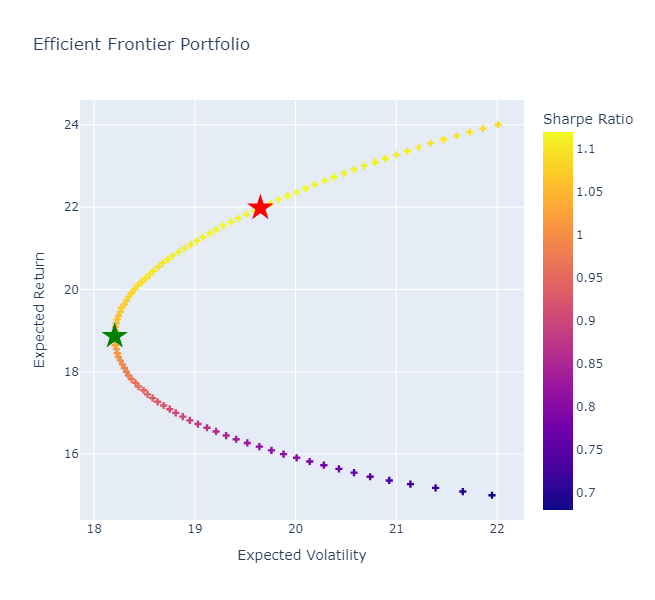

In [27]:
# Plot efficient frontier portfolio
fig = px.scatter(
    efport, x='targetvols', y='targetrets',  color='targetsharpe',
    labels={'targetrets': 'Expected Return', 'targetvols': 'Expected Volatility','targetsharpe': 'Sharpe Ratio'},
    title="Efficient Frontier Portfolio"
     ).update_traces(mode='markers', marker=dict(symbol='cross'))


# Plot maximum sharpe portfolio
fig.add_scatter(
    mode='markers',
    x=[100*portfolio_stats(opt_sharpe['x'])[1]], 
    y=[100*portfolio_stats(opt_sharpe['x'])[0]],
    marker=dict(color='red', size=20, symbol='star'),
    name = 'Max Sharpe'
).update(layout_showlegend=False)

# Plot minimum variance portfolio
fig.add_scatter(
    mode='markers',
    x=[100*portfolio_stats(opt_var['x'])[1]], 
    y=[100*portfolio_stats(opt_var['x'])[0]],
    marker=dict(color='green', size=20, symbol='star'),
    name = 'Min Variance'
).update(layout_showlegend=False)

# Show spikes
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()